In [21]:
library(jsonlite)
source('../models/lung/calibration_wrapper.R')
N_MATRICES <- 1
STARTING_MATRIX <- 1
f <- function(pars) {
    calib.f <- make.calibration.func('','','')
    result <- fromJSON(calib.f(pars))
    return(sum(unlist(result) * c(.45, .45, .1)))
}

In [27]:
options(repr.plot.width=17, repr.plot.height=14)

library(plyr)
library(dplyr)
library(ggplot2)
library(cowplot)
library(hydroPSO)
library(data.table)
library(doParallel)
library(RColorBrewer)
library(MASS)
library(kernlab)
library(reshape2)
library(hydroPSO)

# Objective function
#f <- function(x) .2*sin(.2*x[[1]]*x[[2]]) + 1.5*sin(.2*x[[1]])
#f <- function(x) 2*sin(.1*x[[1]]*x[[2]])
#f <- function(x) sin(2*x[[1]]) - .1*x[[2]]*cos(3*x[[2]])
#f <- function(x) sin(2*x[[1]]) - .1*x[[2]]*cos(3*x[[2]]) + .2*sin(x[[1]]*x[[2]])
#f <- function(x) x[[1]]^2 - 2*x[[2]] + cos(3*x[[1]])*sin(5*x[[2]])
#f.noise <- 1e-7

# GP prior mean
prior.mu <- function(x) 0

# OAK parameters
input.means <- c(5, 5)
input.vars <- c(2, 2)

initial.guess <- c(0.0000014899094538366, 0.00005867, 0.0373025655099923, 0.45001903545473, 
                    0.0310692140027966, 2.06599720339873e-06, 0.083259360316924, 0.0310687721751887, 
                    2.50782481130141e-06, 0.031069806, 1.47440016369862e-06)
lower.limits <- initial.guess * .5
upper.limits <- initial.guess * 1.5

# Other values
seed <- 293526
n.cores <- 8
n.points <- 100
n.points.test <- 1000
seed.test <- 123

# Kernel types: se, ak, ak1, ak2, oak.gaussian

# Performance measures: loglikelihood, test.mse
performance.measure <- 'test.mse'

In [24]:
# Function definitions

get.init.params <- function(kernel.type) {
    if (kernel.type == 'se') {
      initial.pars <- c(1, 1)
      lower.bounds <- c(.01, .1)
      upper.bounds <- c(10, 10)
    } else if (kernel.type == 'ak') {
      initial.pars <- c(1, 1, 1, 1)
      lower.bounds <- c(.01, .01, 0, 0)
      upper.bounds <- c(10, 10, 10, 10)
    } else if (kernel.type == 'ak1') {
      initial.pars <- c(1, 1, 1)
      lower.bounds <- c(.01, .01, .1)
      upper.bounds <- c(10, 10, 10)
    } else if (kernel.type == 'ak2') {
      initial.pars <- c(1, 1, 1)
      lower.bounds <- c(.01, .01, .1)
      upper.bounds <- c(10, 10, 10)
    } else if (kernel.type == 'oak.gaussian') {
      initial.pars <- c(1, 1, 1, 1, 1)
      lower.bounds <- c(.01, .01, 0, 0, 0)
      upper.bounds <- c(10, 10, 10, 10, 10)
    } else if (kernel.type == 'oak.gaussian0') {
      initial.pars <- c(1)
      lower.bounds <- c(0)
      upper.bounds <- c(10)
    } else if (kernel.type == 'oak.gaussian1') {
      initial.pars <- c(1, 1, 1)
      lower.bounds <- c(.01, .01, 0)
      upper.bounds <- c(10, 10, 10)
    } else if (kernel.type == 'oak.gaussian2') {
      initial.pars <- c(1, 1, 1)
      lower.bounds <- c(.01, .01, 0)
      upper.bounds <- c(10, 10, 10)
    }
    return(list(
        initial.pars=initial.pars,
        lower.bounds=lower.bounds,
        upper.bounds=upper.bounds
    ))
}

build.k <- function(type, l, sigma2) {
  if (type == 'se') {
    k <- function(x,x2) {
      kernel <- rbfdot(sigma=1/(2*l^2))
      k <- kernelMatrix(kernel, as.matrix(x), as.matrix(x2))
      return(sigma2*k)
    }
    return(k)
  } else if (type == 'ak') {
    k <- function(x,x2) {
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k1 <- kernelMatrix(kernel1, as.matrix(x[,1]), as.matrix(x2[,1]))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      return(sigma2[1]*(k1 + k2) + sigma2[2]*k1*k2)
    }
    return(k)
  } else if (type == 'ak1') {
    k <- function(x,x2) {
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k1 <- kernelMatrix(kernel1, as.matrix(x[,1]), as.matrix(x2[,1]))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      return(sigma2[1]*(k1 + k2))
    }
    return(k)
  } else if (type == 'ak2') {
    k <- function(x,x2) {
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k1 <- kernelMatrix(kernel1, as.matrix(x[,1]), as.matrix(x2[,1]))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      return(sigma2[2]*k1*k2)
    }
    return(k)
  } else if (type == 'oak.gaussian') {
    k <- function(x,x2) {
      m1 <- as.matrix(x[,1])
      m2 <- as.matrix(x2[,1])
        
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))        
      kerneld <- function(x1,x2) {
          -(2*crossprod(x1,x2) - crossprod(x1) - crossprod(x2))
      }       
        
      k1 <- kernelMatrix(kernel1, m1, m2)       
      exp.numerator1 <- -log(kernelMatrix(rbfdot(), m1-input.means[1], m2-input.means[1]))
      #exp.numerator1 <- (x[,1]-input.means[1])^2 + (x2[,1]-input.means[1])^2
      k1 <- k1 - 
        l[1]*sqrt(l[1]^2+2*input.vars[1]^2)/(l[1]^2+input.vars[1]^2) *
        exp(-exp.numerator1/(2*(l[1]^2+input.vars[1]^2)))
      
        
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      exp.numerator2 <- -log(kernelMatrix(rbfdot(), m1-input.means[2], m2-input.means[2]))
      #exp.numerator2 <- (x[,2]-input.means[2])^2 + (x2[,2]-input.means[2])^2
      k2 <- k2 - 
        l[2]*sqrt(l[2]^2+2*input.vars[2]^2)/(l[2]^2+input.vars[2]^2) *
        exp(-exp.numerator2/(2*(l[2]^2+input.vars[2]^2)))
      return(sigma2[1] + sigma2[2]*(k1 + k2) + sigma2[3]*k1*k2)
    }
    return(k)
  } else if (type == 'oak.gaussian0') {
    k <- function(x,x2) {
      return(matrix(sigma2[1], nrow=nrow(x), ncol=nrow(x2)))
    }
    return(k)
  } else if (type == 'oak.gaussian1') {
    k <- function(x,x2) {
      m1 <- as.matrix(x[,1])
      m2 <- as.matrix(x2[,1])
        
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))        
      kerneld <- function(x1,x2) {
          -(2*crossprod(x1,x2) - crossprod(x1) - crossprod(x2))
      }       
        
      k1 <- kernelMatrix(kernel1, m1, m2)       
      exp.numerator1 <- -log(kernelMatrix(rbfdot(), m1-input.means[1], m2-input.means[1]))
      #exp.numerator1 <- (x[,1]-input.means[1])^2 + (x2[,1]-input.means[1])^2
      k1 <- k1 - 
        l[1]*sqrt(l[1]^2+2*input.vars[1]^2)/(l[1]^2+input.vars[1]^2) *
        exp(-exp.numerator1/(2*(l[1]^2+input.vars[1]^2)))
      
        
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      exp.numerator2 <- -log(kernelMatrix(rbfdot(), m1-input.means[2], m2-input.means[2]))
      #exp.numerator2 <- (x[,2]-input.means[2])^2 + (x2[,2]-input.means[2])^2
      k2 <- k2 - 
        l[2]*sqrt(l[2]^2+2*input.vars[2]^2)/(l[2]^2+input.vars[2]^2) *
        exp(-exp.numerator2/(2*(l[2]^2+input.vars[2]^2)))
      return(sigma2[2]*(k1 + k2))
    }
    return(k)
  } else if (type == 'oak.gaussian2') {
    k <- function(x,x2) {
      m1 <- as.matrix(x[,1])
      m2 <- as.matrix(x2[,1])
        
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))        
      kerneld <- function(x1,x2) {
          -(2*crossprod(x1,x2) - crossprod(x1) - crossprod(x2))
      }       
        
      k1 <- kernelMatrix(kernel1, m1, m2)       
      exp.numerator1 <- -log(kernelMatrix(rbfdot(), m1-input.means[1], m2-input.means[1]))
      #exp.numerator1 <- (x[,1]-input.means[1])^2 + (x2[,1]-input.means[1])^2
      k1 <- k1 - 
        l[1]*sqrt(l[1]^2+2*input.vars[1]^2)/(l[1]^2+input.vars[1]^2) *
        exp(-exp.numerator1/(2*(l[1]^2+input.vars[1]^2)))
      
        
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      exp.numerator2 <- -log(kernelMatrix(rbfdot(), m1-input.means[2], m2-input.means[2]))
      #exp.numerator2 <- (x[,2]-input.means[2])^2 + (x2[,2]-input.means[2])^2
      k2 <- k2 - 
        l[2]*sqrt(l[2]^2+2*input.vars[2]^2)/(l[2]^2+input.vars[2]^2) *
        exp(-exp.numerator2/(2*(l[2]^2+input.vars[2]^2)))
      return(sigma2[3]*k1*k2)
    }
    return(k)
  }
}

calculate.regression.model <- function(X, y, k) {
  if (nrow(X) == 0) {
    K <- numeric(0)
    Ki <- K
  } else {
    K <- k(X,X)
    if (nrow(X) == 1) {
      Ki <- 1/(K + f.noise)
    } else {
      # ginv vs solve
      Ki <- solve(matrix(unlist(K),nrow=nrow(K)) + f.noise*diag(nrow(K)))
    }
  }
  
  fs <- function(Xs) {
    if (nrow(X) == 0)
      return(prior.mu(Xs))
    
    Ks <- k(Xs, X)
    # Ks <- matrix(unlist(Ks),nrow=nrow(Ks))
    return(prior.mu(Xs) + Ks %*% Ki %*% (y - prior.mu(Xs)))
  }
  
  
  sigma <- function(Xs) {
    Kss <- k(Xs, Xs)
    # Kss <- apply(Xs, 1, function(r) k(r,r))
    
    if (nrow(X) == 0)
      return(Kss)
    
    Ks <- k(Xs, X)
    S <- Kss - Ks %*% Ki %*% t(Ks)
    # if (Xs %in% observed.x && f.noise == 0)
    #   S <- matrix(0) # Due to numerical instability values already observed haved a non-zero sigma, forcing 0 here
    S <- apply(S, 1:2, function(x) max(x,0)) # Numerical instability, (small) negative values should be 0
    return(S)
  }
  
  if (nrow(X) == 0) {
    best.x <- c(0,0)
    best.y <- prior.mu(c(0,0))
  } else {
    best.x <- X[which.max(y),]
    best.y <- max(y)
  }
  
  return(list(mean=fs, cov=sigma, best.x=best.x, best.y=best.y, K=K))
}

calculate.loglik <- function(gp.model, observed.x, observed.y) {
  Lu <- matrix(chol(gp.model$K), nrow=nrow(gp.model$K))
  Ll <- t(Lu)
  S1 <- forwardsolve(Ll, observed.y)
  S2 <- backsolve(Lu, S1)
  
  log.lik <- -sum(log(diag(Ll))) - .5 * observed.y %*% S2 - 0.5 * nrow(observed.x) + log(2*pi)
  return(log.lik)
}

calculate.test.mse <- function(gp.model, observed.x, observed.y) {
  if (!is.null(seed.test))
      set.seed(seed.test)
  x.test <- data.frame(x1=runif(n.points.test, x.limits[1], x.limits[2]), 
                       x2=runif(n.points.test, y.limits[1], y.limits[2]))
  
  y.test <- apply(x.test, 1, f)
  y.model <- gp.model$mean(x.test)
  
  mse <- mean((y.test - y.model)^2)
  return(mse)
} 

if (performance.measure == 'loglikelihood') {
  calculate.performance <- calculate.loglik
  fnscale <- -1
} else if (performance.measure == 'test.mse') {
  calculate.performance <- calculate.test.mse
  fnscale <- 1
}

In [25]:
# Define hyperparameter optimization

calculate.params.ll <- function(pars, kernel.type, verbose=TRUE) {
  if (kernel.type == 'se') {
      l <- pars[1]
      sigma2 <- pars[2]
  } else if (kernel.type == 'ak') {
      l <- pars[1:2]
      sigma2 <- pars[3:4]
  } else if (kernel.type == 'ak1') {
      l <- pars[1:2]
      sigma2 <- pars[3]
  } else if (kernel.type == 'ak2') {
      l <- pars[1:2]
      sigma2 <- pars[3]
  } else if (kernel.type == 'oak.gaussian') {
      l <- pars[1:2]
      sigma2 <- pars[3:5]
  }
  
  k <- build.k(kernel.type, l, sigma2)
  
  lapply(initial.guess, function(xi) runif(n.points, xi*.5, xi*1.5))
    
  observed.x <- data.frame(x1=runif(n.points, x.limits[1], x.limits[2]), 
                           x2=runif(n.points, y.limits[1], y.limits[2]))
  observed.y <- apply(observed.x, 1, f)
  
  gp.model <- calculate.regression.model(observed.x, observed.y, k)
  
  perf <- calculate.performance(gp.model, observed.x, observed.y)
  
  if (plot.gps) {
    cl <- makeCluster(n.cores)
    clusterExport(cl, ls(1))
    registerDoParallel(cl)
    
    df.f.model <- df.f
    df.f.model$z <- foreach(x=iter(xx, by='row'), .combine='c') %dopar% {
      gp.model$mean(data.frame(x))
    }
    
    stopCluster(cl)
    
    plt <- ggplot(df.f.model, aes(x=x, y=y, z=z)) +
      geom_contour_filled(
        breaks=color.breaks
      ) +
      geom_point(data=observed.x, aes(x=x1, y=x2, z=NULL)) +
      scale_fill_viridis_d(drop=FALSE) +
      theme(legend.position = "none") +
      xlab('') +
      ylab('') +
      ggtitle(paste0('Gaussian process (Log-likelihood: ', perf, ')'))
  
    plt2 <- plot_grid(plt.f, plt, ncol=2, align='h')
    print(plt2)
  }
  
  if (performance.measure == 'loglikelihood') perf.name <- 'll'
  else if (performance.measure == 'test.mse') perf.name <- 'mse'
  if (verbose) {
      message(paste0('l=',paste0(l, collapse=','),
                     ', sigma2=', paste0(sigma2, collapse=','), ' (', perf.name, '=', perf, ')'), appendLF=FALSE )
  }
  return(perf)
}


# Squared Exponential kernel optimization

In [26]:
set.seed(1321213)
kernel.type <- 'se'
optim.params <- get.init.params(kernel.type)

optim.result <- hydroPSO(par=optim.params$initial.pars,
                      #method='SAN',
                      #method='L-BFGS-B',
                      fn=calculate.params.ll,
                      lower=optim.params$lower.bounds,
                      upper=optim.params$upper.bounds,
                      control=list(
                        pgtol=0,
                        fnscale=fnscale,
                        temp=1000,
                        tmax=1000,
                        maxit=10000
                        ),
                      kernel.type=kernel.type
                      )
cat('\nOptimization results:', sep='\n')
cat(paste0(' Params=', paste0(optim.result$par, collapse=',')), sep='\n')
cat(paste0(' Performance=', optim.result$value), sep='\n')

l.se <- optim.result$par[1]
sigma2.se <- optim.result$par[2]

Warning message in hydroPSO(par = optim.params$initial.pars, fn = calculate.params.ll, :
“[Unknown names in control: pgtol, fnscale, temp, tmax (not used) !]”
                                                                                


[                                Initialising  ...                             ]


                                                                                

[npart=40 ; maxit=10000 ; method=spso2011 ; topology=random ; boundary.wall=absorbing2011]

         

[ user-definitions in control: maxit=10000 ]

         

                                                                                


[ Writing the 'PSO_logfile.txt' file ...                                       ]


                                                                                


[                                 Running  PSO ...                             ]


                                                                                



ERROR: Error in runif(n.points, x.limits[1], x.limits[2]): object 'x.limits' not found


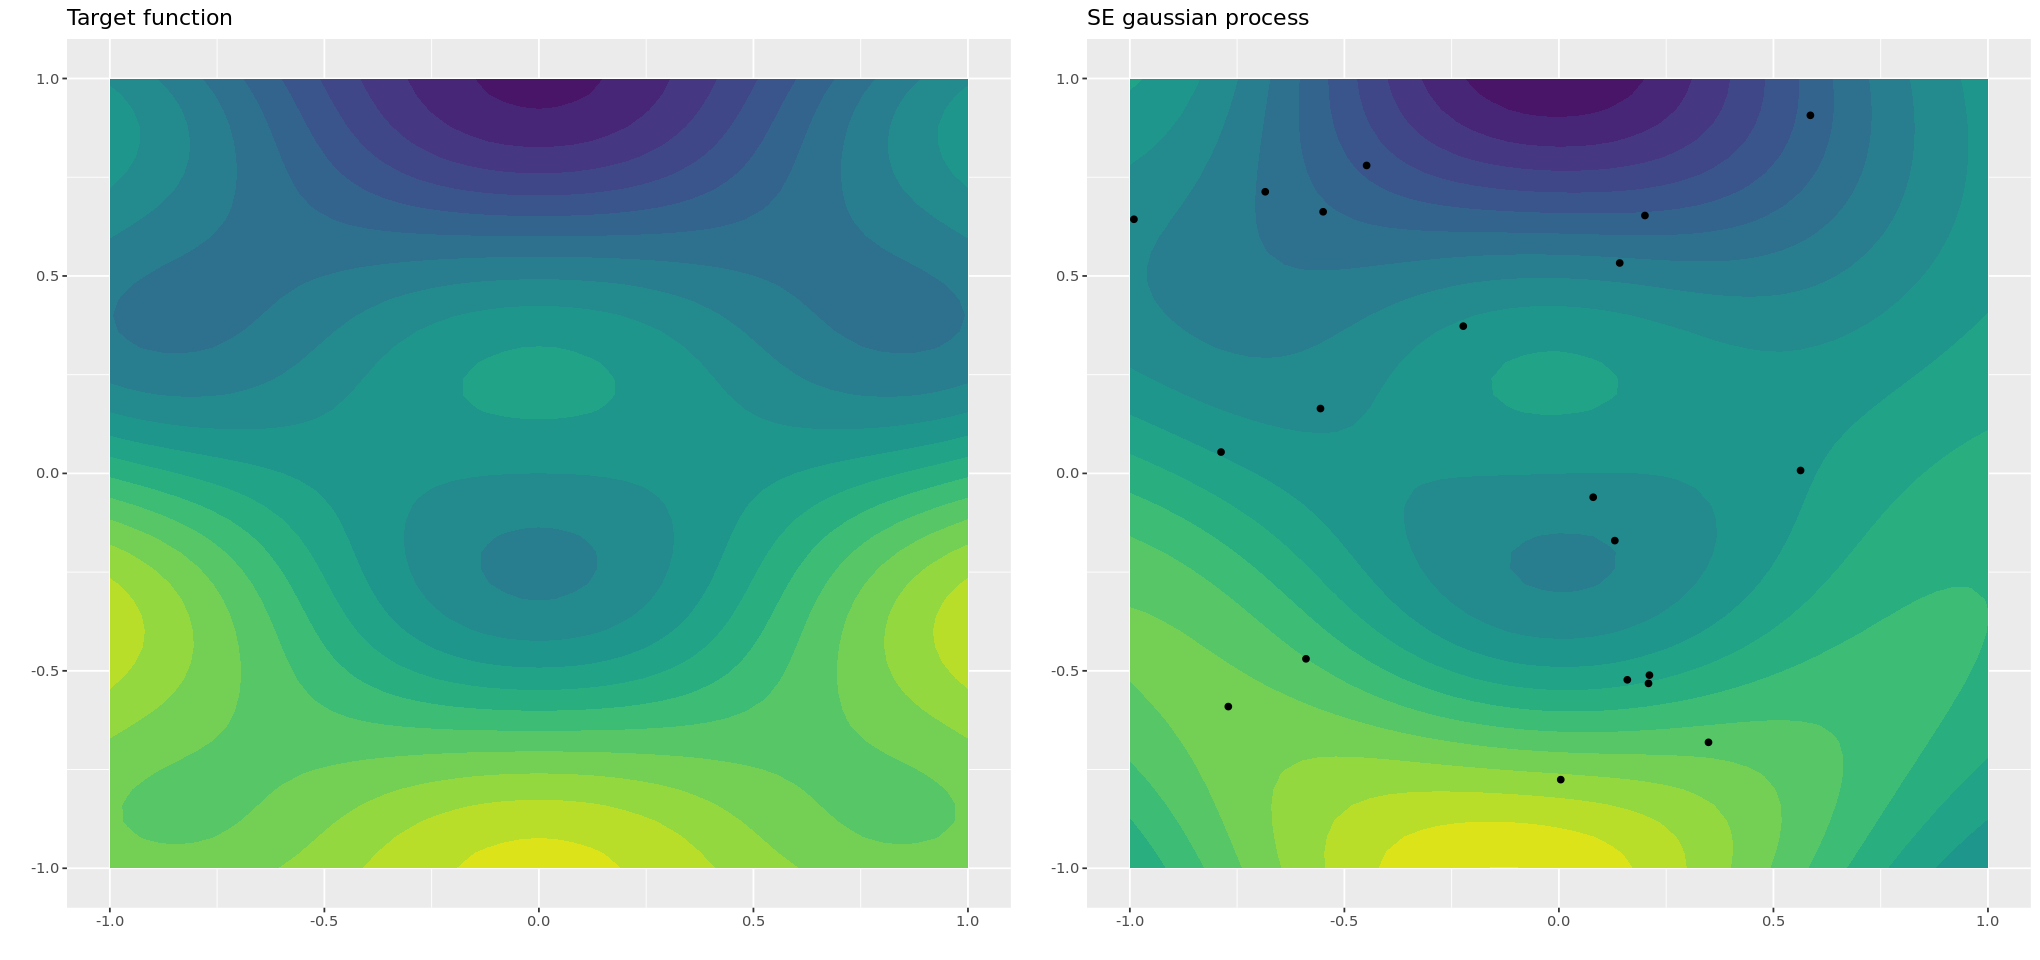

In [737]:
# Plot SE-GP with fitted hyperparameters

n.plot.train.points <- 20
set.seed(221)

observed.x <- data.frame(x1=runif(n.plot.train.points, x.limits[1], x.limits[2]), 
                         x2=runif(n.plot.train.points, y.limits[1], y.limits[2]))
observed.y <- apply(observed.x, 1, f)

kernels <- list(build.k('se', l.se, sigma2.se))
titles <- list('SE gaussian process')

plots <- list(plt.f)
for(i in seq_along(kernels)) {
    k <- kernels[[i]]
    title <- titles[[i]]
    gp.model <- calculate.regression.model(observed.x, observed.y, k)

    df.f.model <- df.f
    df.f.model$z <- gp.model$mean(xx)

    plt <- ggplot(df.f.model, aes(x=x, y=y, z=z)) +
      geom_contour_filled(
        breaks=color.breaks
      ) +
      geom_point(data=observed.x, aes(x=x1, y=x2, z=NULL)) +
      scale_fill_viridis_d(drop=FALSE) +
      theme(legend.position = "none") +
      xlab('') +
      ylab('') +
      ggtitle(title)
    plots <- append(plots, list(plt))
}

options(repr.plot.width=17, repr.plot.height=8)
plt2 <- plot_grid(plotlist=plots, ncol=2, align='h')
print(plt2)

# Additive kernel optimization

In [30]:
set.seed(168203)
kernel.type <- 'ak'
optim.params <- get.init.params(kernel.type)

optim.result <- #hydroPSO(par=optim.params$initial.pars,
                optim(par=optim.params$initial.pars,
                      method='SAN',
                      #method='L-BFGS-B',
                      fn=calculate.params.ll,
                      lower=optim.params$lower.bounds,
                      upper=optim.params$upper.bounds,
                      control=list(
                        pgtol=0,
                        fnscale=fnscale,
                        parscale=rep(100,4),
                        temp=1000,
                        tmax=1000,
                        maxit=10000
                        ),
                      kernel.type=kernel.type
                      )
cat('\nOptimization results:', sep='\n')
cat(paste0(' Params=', paste0(optim.result$par, collapse=',')), sep='\n')
cat(paste0(' Performance=', optim.result$value), sep='\n')
cat(paste0(' Variance: ', 
           paste0(formatC(optim.result$par[3:4]*100/sum(optim.result$par[3:4]), 
                          format='f', digits=2), '%', collapse = ', '), 
         sep='\n'))

l.ak <- optim.result$par[1:2]
sigma2.ak <- optim.result$par[3:4]

Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”


ERROR: Error in runif(n.points, x.limits[1], x.limits[2]): object 'x.limits' not found


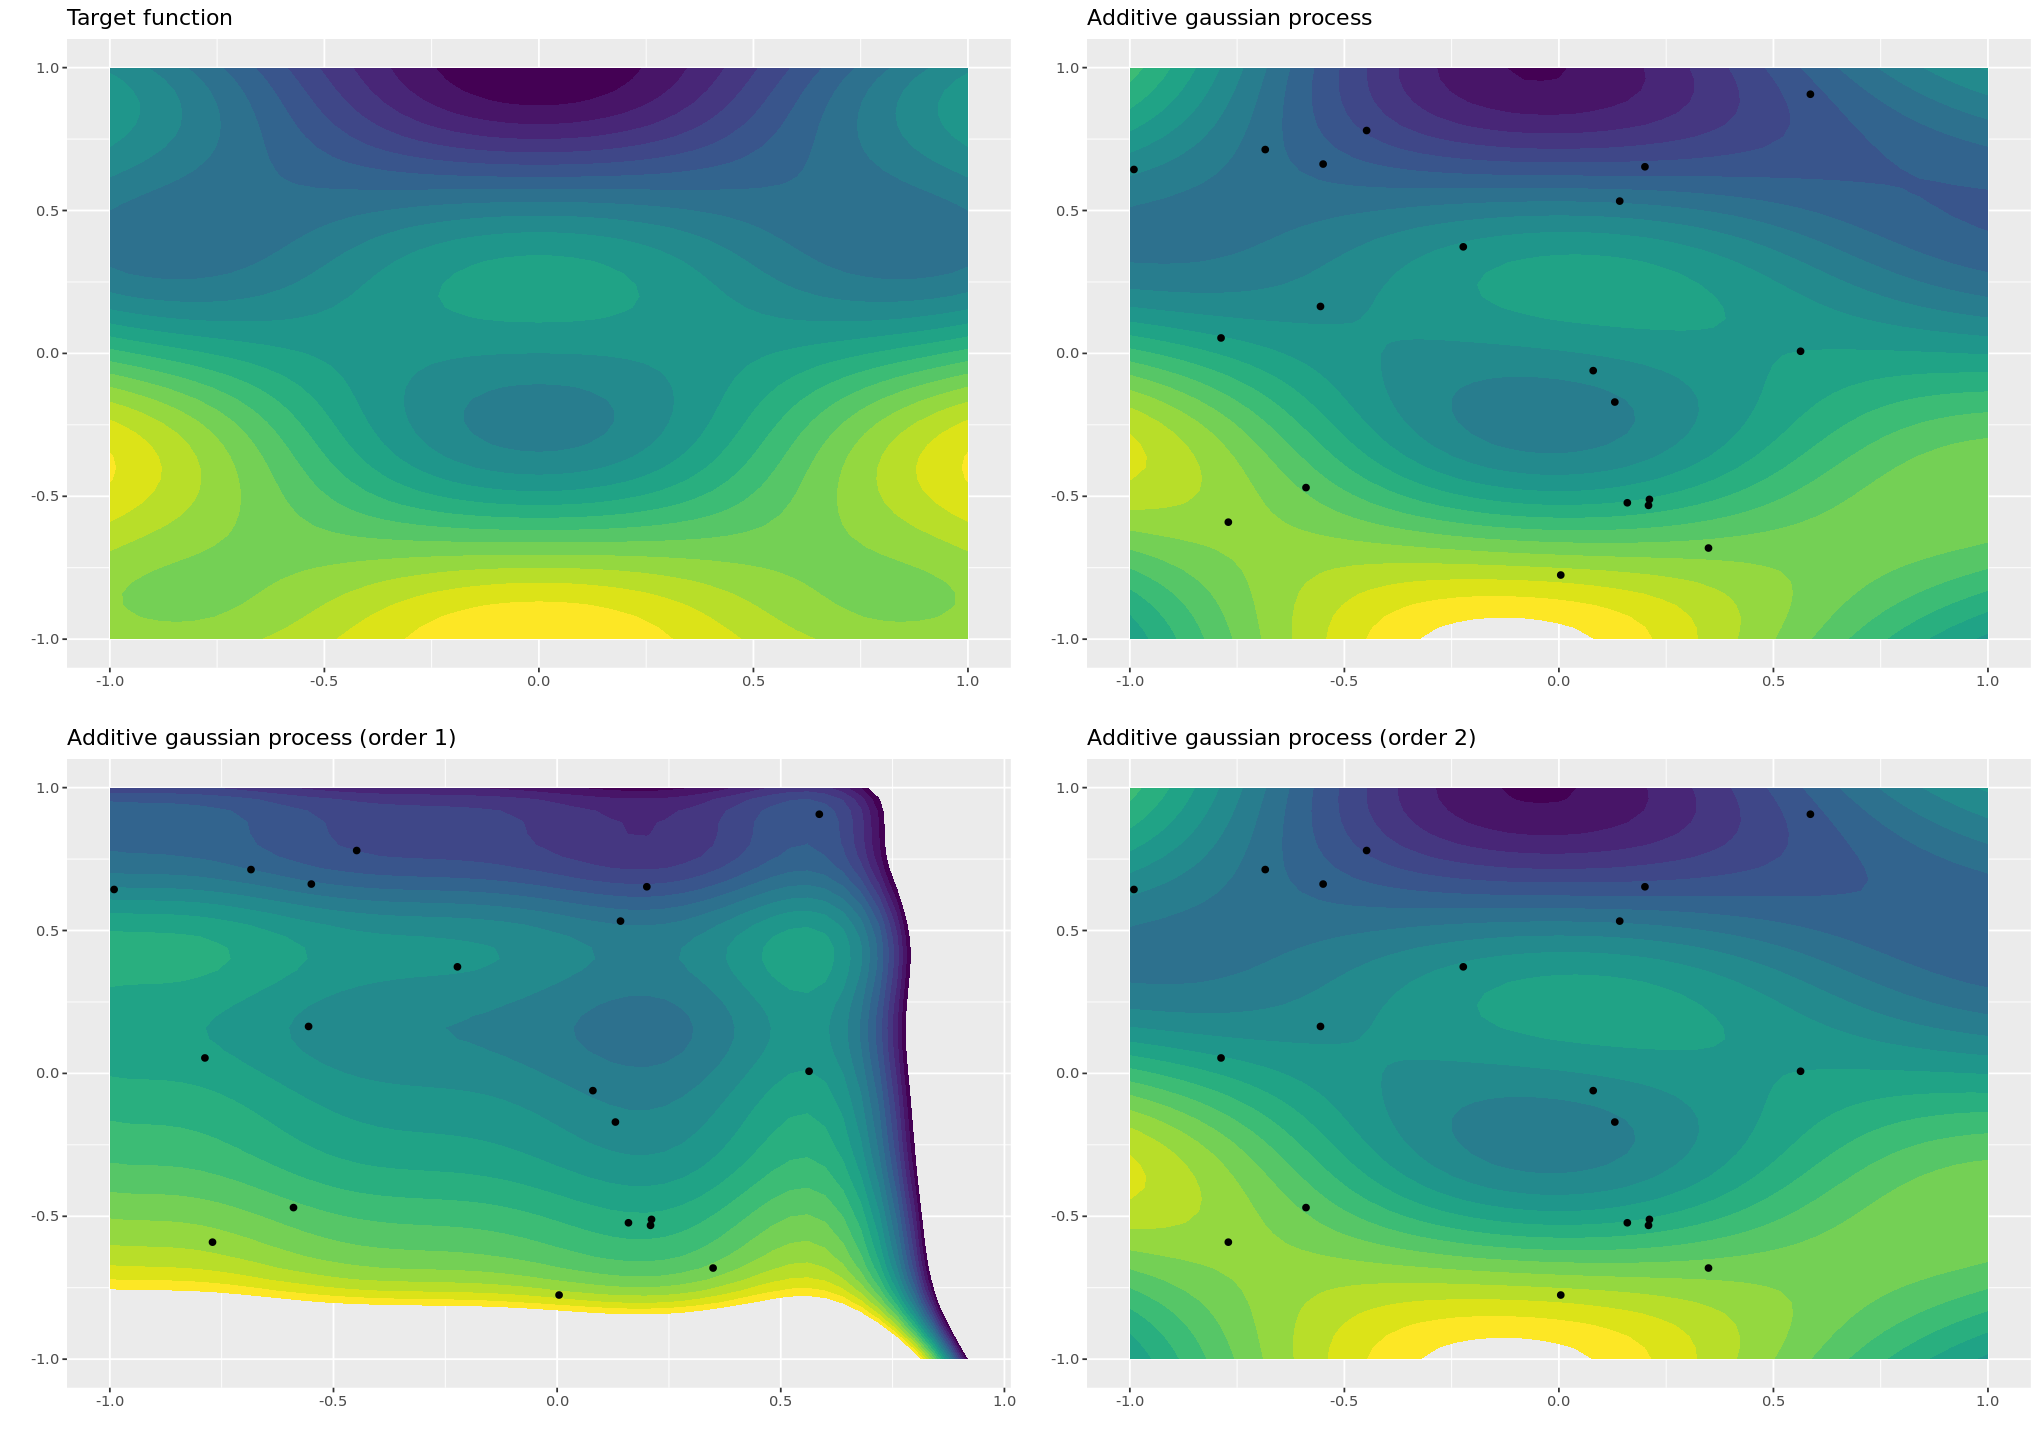

In [705]:
# Plot AK-GP with fitted hyperparameters

l.ak.plot <- l.ak
sigma2.ak.plot <- sigma2.ak
n.plot.train.points <- 20
set.seed(221)

observed.x <- data.frame(x1=runif(n.plot.train.points, x.limits[1], x.limits[2]), 
                         x2=runif(n.plot.train.points, y.limits[1], y.limits[2]))
observed.y <- apply(observed.x, 1, f)

kernels <- list(build.k('ak', l.ak.plot, sigma2.ak.plot),
                build.k('ak1', l.ak.plot, sigma2.ak.plot),
                build.k('ak2', l.ak.plot, sigma2.ak.plot))
titles <- list('Additive gaussian process', 'Additive gaussian process (order 1)', 'Additive gaussian process (order 2)')

plots <- list(plt.f)
for(i in seq_along(kernels)) {
    k <- kernels[[i]]
    title <- titles[[i]]
    gp.model <- calculate.regression.model(observed.x, observed.y, k)

    df.f.model <- df.f
    df.f.model$z <- gp.model$mean(xx)

    plt <- ggplot(df.f.model, aes(x=x, y=y, z=z)) +
      geom_contour_filled(
        breaks=color.breaks
      ) +
      geom_point(data=observed.x, aes(x=x1, y=x2, z=NULL)) +
      scale_fill_viridis_d(drop=FALSE) +
      theme(legend.position = "none") +
      xlab('') +
      ylab('') +
      ggtitle(title)
    plots <- append(plots, list(plt))
}

options(repr.plot.width=17, repr.plot.height=12)
plt2 <- plot_grid(plotlist=plots, ncol=2, align='h')
print(plt2)

# Orthogonal additive kernel optimization

In [716]:
set.seed(1131)
kernel.type <- 'oak.gaussian'
optim.params <- get.init.params(kernel.type)

optim.result <- hydroPSO(par=optim.params$initial.pars,
                      #method='SAN',
                      #method='L-BFGS-B',
                      fn=calculate.params.ll,
                      lower=optim.params$lower.bounds,
                      upper=optim.params$upper.bounds,
                      control=list(
                        pgtol=0,
                        fnscale=fnscale,
                        parscale=100,
                        temp=10000,
                        tmax=10000,
                        maxit=10000
                        ),
                      kernel.type=kernel.type
                      )
cat('\nOptimization results:', sep='\n')
cat(paste0(' Params=', paste0(optim.result$par, collapse=',')), sep='\n')
cat(paste0(' Performance=', optim.result$value), sep='\n')
cat(paste0(' Variance: ', 
           paste0(formatC(optim.result$par[3:5]*100/sum(optim.result$par[3:5]), 
                          format='f', digits=2), '%', collapse = ', '), 
         sep='\n'))

l.oak.gaussian <- optim.result$par[1:2]
sigma2.oak.gaussian <- optim.result$par[3:5]

Warning message in hydroPSO(par = optim.params$initial.pars, fn = calculate.params.ll, :
“[Unknown names in control: pgtol, fnscale, temp, tmax (not used) !]”
                                                                                


[                                Initialising  ...                             ]


                                                                                

[npart=40 ; maxit=10000 ; method=spso2011 ; topology=random ; boundary.wall=absorbing2011]

         

[ user-definitions in control: maxit=10000 ]

         

                                                                                


[ Writing the 'PSO_logfile.txt' file ...                                       ]


                                                                                


[                                 Running  PSO ...                             ]


                                                                                

l=1,1, sigma2=1,1,1

l=1.42716178302594,5.59877226421386, sigma2=6.21092614542794,5.16660375962664,4.40650676673641 (mse=0.0837532588089338)
l=8.16116090685684,5.38544614869216, sigma2=5.78767526561587,5.77599858961861,7.55386644864902 (mse=0.25406051719441)
l=7.50576023476119,4.8116503334337, sigma2=7.57301607742702,2.78026421951401,8.20841752929105 (mse=0.257291669656123)
l=7.1508807751249,7.74161954394174, sigma2=7.49392001355642,0.243904910640527,3.2764678205169 (mse=0.252351494594437)
l=5.16307576026456,2.08003806327082, sigma2=6.30421017945638,5.81479035585243,6.29436212252821 (mse=0.0841127870224098)
l=3.43633280379523,3.75775328345072, sigma2=8.32321392961606,2.01727135164407,4.95634534931145 (mse=0.192110707383014)
l=7.02679592280459,3.95759703767249, sigma2=1.37861116435182,7.75879605154435,8.11149615952341 (mse=0.255752702730942)
l=9.01371273517245,1.50264056778896, sigma2=2.14249516613612,4.73228418951841,1.91640403229567 (mse=0.170336697089869)
l=3.23046935802717,3.10005258660873, sigma2=3.539

l=0.632643857546548,1.5720522826146, sigma2=1.11752540048906,3.27525558630405,8.5468788006594 (mse=0.00899382049484869)
l=1.69368476523151,1.02038516854273, sigma2=7.15507500378321,2.03193707273942,2.97282237784744 (mse=0.00533514307487385)
l=0.270142307291135,0.01, sigma2=7.48695685915451,2.63028437115249,2.29794027014648 (mse=0.745131687437317)
l=1.10738188412162,8.41390178249055, sigma2=7.27034665719697,10,4.81473294320507 (mse=0.127364081911103)
l=5.377137719412,9.43403429097842, sigma2=5.34751528348613,8.46395265144688,7.85721374851146 (mse=0.415708161108259)
l=6.74894148675505,1.54138596338687, sigma2=2.50082541200179,2.1519724951594,4.97919504948039 (mse=0.0799367532809218)
l=6.39476152634787,9.65074418918698, sigma2=10,1.77110895437673,5.75035643509901 (mse=0.254694793835413)
l=5.84273473020795,0.739214510861937, sigma2=7.55293669222429,8.55301155367977,0.171590345605301 (mse=0.0422196207633295)
l=2.34827968036516,3.42487542278402, sigma2=5.32804170984159,0.426589485442045,2.39

l=0.01,2.86002689899064, sigma2=7.33624541987669,8.72549964275332,5.64674711571924 (mse=1.32750444598925)
l=4.494059109968,1.13059888479851, sigma2=2.38266336916066,6.34210655961704,3.95750660925428 (mse=0.0581337480937287)
l=2.95938468955795,5.61730574867965, sigma2=7.73109622384287,0.0444893661026846,7.37994388904088 (mse=0.394094786450933)
l=4.63668040967074,7.18922902461006, sigma2=9.55266158102335,5.1058959274446,2.2482286303459 (mse=0.255007196882587)
l=6.41123747114682,0.322893347577128, sigma2=7.25356709559253,4.14988769842834,1.80024458818557 (mse=0.0253795093451876)
l=7.90256838791229,1.16531360203526, sigma2=4.9639246575186,9.24542219528735,6.70673796414752 (mse=0.069470579822453)
l=2.59155071062049,4.66280752555839, sigma2=5.4223525399454,6.18466197022107,4.91917871571671 (mse=0.122741906795704)
l=0.219277057718058,3.40748967084827, sigma2=0.460710668014705,3.16222854547557,7.11966512820074 (mse=6.82105289328986)
l=0.904924729824126,0.01, sigma2=9.50870086050101,1.635262575

l=2.48702734003681,1.56466395823071, sigma2=2.7201656975763,1.54924905983305,1.03719645838141 (mse=0.107208871212821)
l=5.91651238722104,4.06538657925042, sigma2=4.07120401880124,5.16776509315383,2.98417917078272 (mse=0.256285595973135)
l=2.94927458046311,3.3952960036476, sigma2=8.01186410041778,7.61369769712155,4.90016025494749 (mse=0.0891629804111492)
l=6.42348280123747,1.66977871730401, sigma2=3.63834282840657,9.39773647269213,7.50774614334283 (mse=0.0791628528604141)
l=1.50417784897227,8.271830520103, sigma2=2.24453669922876,4.76684520252937,4.39522763907069 (mse=0.208900111167033)
l=9.56955279360905,1.96779272891925, sigma2=4.07960258465431,7.08201396506193,9.49316574021108 (mse=0.187803711326395)
l=4.23858268475026,1.53448476852069, sigma2=7.78118549009125,5.87691032145102,4.11267068996773 (mse=0.0918087732616749)
l=4.68164278692883,0.231576703614018, sigma2=2.07100203105251,10,6.56648349615757 (mse=0.0586074782628088)
l=0.692579574731698,2.89115702772189, sigma2=5.67905885563312

l=0.01,0.617039676296538, sigma2=7.74201820891665,1.50228764297744,4.67825068338706 (mse=0.535809315578221)
l=1.07999230417697,2.15271880650886, sigma2=6.83461938811684,5.78094363730844,1.46047677490714 (mse=0.0861184857111017)
l=8.47188034389735,0.362903350259143, sigma2=0,4.0996265997717,6.47554845897455 (mse=0.0235365455241535)
l=8.45656657480937,0.445659362992245, sigma2=5.2857484775116,5.29485650576093,5.18348232215421 (mse=0.022633889981979)
l=5.69319265916558,0.695387268257616, sigma2=2.42189712981449,6.3629922344126,6.37691360575778 (mse=0.0222058515637215)
l=0.01,1.15159458962519, sigma2=5.09641459968152,8.66212096212671,6.56020886699924 (mse=0.825255654479581)
l=6.45930581602864,0.827374008563624, sigma2=9.16357928993914,4.88003086260391,2.07789326713747 (mse=0.037869040799315)
l=1.15260716656587,2.15557921827315, sigma2=8.48477929675798,3.28414441981647,1.34961072605637 (mse=0.0891950650700301)
l=1.72281709821034,1.08145840301647, sigma2=5.17053983187649,1.39125836728692,1.2

l=6.64899191429816,0.706774349882755, sigma2=4.58781534694236,8.96439930314521,8.71374056371135 (mse=0.0217476367576516)
l=0.390702553436629,1.83408134204929, sigma2=10,0,5.31069029508769 (mse=0.0314209022828059)
l=1.45771371875173,0.467650669000917, sigma2=7.16546913817162,5.93035813025715,1.94028976432714 (mse=7.3596039989384e-05)
l=0.01,2.54162013889102, sigma2=6.44663864233475,2.56444782954777,1.54553574136961 (mse=1.25511716319408)
l=10,0.183924547473808, sigma2=4.5624995001652,4.2603445974158,10 (mse=0.0755104115884577)
l=5.62901972099469,0.574462454521684, sigma2=5.54721303860862,1.63806623254171,1.19255639309196 (mse=0.0210074381758962)
l=5.15498529498483,0.01, sigma2=7.43224325586142,8.68254494114294,9.79898656902549 (mse=6.57419498029426)
l=6.79395868494182,0.244384838816338, sigma2=2.01267207305719,3.86444361759884,2.30833508560602 (mse=0.0387464155966504)
l=0.926460318505039,0.810701582801226, sigma2=9.02610981964601,0.478068081286191,4.25521876990599 (mse=0.000240329120646

l=0.565558518460761,2.4117663292794, sigma2=1.16144597092342,3.17295915209954,8.82329136528779 (mse=0.226492105326546)
l=0.294324550483555,0.442502067293301, sigma2=9.77066871124885,1.57271144293087,3.6672902308156 (mse=0.000315197628703371)
l=2.00355040211362,0.379891173501598, sigma2=8.48431926715612,6.187948709303,3.85936619972328 (mse=0.0179381149929839)
l=0.01,5.87939821115725, sigma2=6.68075465378102,10,4.27594163985141 (mse=2.93228589772651)
l=4.86089788793416,1.73791590055655, sigma2=2.2351663599142,5.69288267464882,8.91064185188249 (mse=0.0899801897351231)
l=2.3561501210041,0.01, sigma2=3.88636306684719,1.69115324033638,4.89080595652965 (mse=0.99680534920338)
l=4.60706762258448,10, sigma2=9.97821665471786,2.75538385114345,2.52159009688627 (mse=0.253210842550391)
l=7.29385263639114,0.600361559027621, sigma2=4.23589700684558,8.18892484815166,1.79510794098002 (mse=0.0210697482196087)
l=3.22999038496295,1.44327008273458, sigma2=8.70857328803828,6.70967583271575,6.50469806840037 (m

l=5.73559443992482,0.918430847059483, sigma2=0.949718169967487,9.71196519566509,8.56630435432516 (mse=0.029510931603183)
l=0.606194677683175,3.35362988774695, sigma2=3.31514342236722,6.22177864481629,8.38958424379526 (mse=0.124899989242648)
l=4.90461888914582,0.236355307892053, sigma2=2.72861027144086,4.36321952525156,4.04475456079402 (mse=0.0560782271644769)
l=1.43269749367892,3.49492495175505, sigma2=4.74573643555566,2.84908799629783,3.84234985517974 (mse=0.107578177552519)
l=3.83826152409653,9.41574987948384, sigma2=10,8.07445778281586,0.549325569223175 (mse=0.252130316317411)
l=4.10637010726462,0.900829366141228, sigma2=9.00416504865423,3.16974545902109,6.08528227941766 (mse=0.0232344712216089)
l=7.3827189685011,0.633507224055578, sigma2=4.48225852598797,8.49449292925868,3.39085452889607 (mse=0.0211688807531152)
l=1.38561219768374,2.47513535287665, sigma2=7.84577978249894,5.85962397445701,3.96516319108699 (mse=0.0996705038200034)
l=0.54268450137068,1.81573467337985, sigma2=0.976434

l=4.30917588567447,0.738417881600623, sigma2=8.53397629441479,6.47613161951961,4.37716990779179 (mse=0.0230870715071413)
l=0.117469744894432,1.05628424784063, sigma2=8.85532342262727,4.07689301793336,1.19296122611233 (mse=0.858925258160821)
l=0.788934190633714,0.579599061436017, sigma2=9.73686504733637,1.94372537256814,3.06901594109806 (mse=0.000268711498784243)
l=4.94666763290445,4.91129178692885, sigma2=5.45653203081203,3.02368669205343,1.16346654227469 (mse=0.257604440176037)
l=1.92896228565884,1.33622510602249, sigma2=8.84501330020714,8.13980823349515,6.13538908774398 (mse=0.00870796279382885)
l=7.58490316098579,1.38207974720348, sigma2=2.50681082703715,8.79790535289662,7.07411274376368 (mse=0.0744831156877298)
l=0.700772486267065,4.85302415734999, sigma2=1.86789386527376,4.28239744634399,4.68625712736697 (mse=0.097194540096216)
l=4.48717626027927,0.196741764030241, sigma2=6.29814870974928,7.42250470089815,6.88754138886174 (mse=0.0888600669287607)
l=1.99698065033431,1.2365903036185

l=9.78770148882418,0.01, sigma2=5.98652410613681,3.87766368678022,8.22954267937941 (mse=12.9090070539483)
l=6.76472864247765,0.578769824665179, sigma2=4.01282047975084,1.01442112408867,3.06443265015109 (mse=0.0205449003366167)
l=5.91282115070407,0.477043281389622, sigma2=5.82853883783266,7.62182414601656,8.05149953930247 (mse=0.024617053091556)
l=7.49022763555882,0.404708831254484, sigma2=3.06833713749166,9.49163682656231,2.39454925275288 (mse=0.023394124559383)
l=0.656725629871422,0.437795974431587, sigma2=9.67414730550266,1.73669619413201,3.63592844295386 (mse=5.59309098113222e-06)
l=0.466895551260884,0.611585729790445, sigma2=8.00955318850558,5.62824333214066,1.04108860903301 (mse=2.12710365753591e-06)
l=7.43729490601217,0.499380897838124, sigma2=0,2.98933362262133,5.36513142672412 (mse=0.0222238461782898)
l=9.29341900989822,0.490186958707814, sigma2=5.03400939874262,5.83678489003955,4.20636657079991 (mse=0.0210289648687048)
l=1.93145521480239,1.01247056516783, sigma2=5.142474707527

l=0.01,5.76729966436722, sigma2=5.76322419161504,10,4.41043307159798 (mse=2.8498574559987)
l=5.38403216925921,0.968018183057012, sigma2=1.89885520959958,4.95554401375651,9.41920943671016 (mse=0.031422384189386)
l=2.57857810326269,0.0416922169135478, sigma2=6.90881846140291,2.63642225166152,4.30552500022412 (mse=0.699078237930954)
l=6.19066968311062,9.1228485445849, sigma2=9.53242630131912,7.59660073377261,3.56307143987394 (mse=0.251243977535438)
l=6.32112721574811,0.750978008173666, sigma2=4.88697038091745,8.86576461416516,1.35025246121335 (mse=0.0297065634841352)
l=1.4749725695803,0.626406708733696, sigma2=8.80467677870154,7.82937025185835,6.33917235591858 (mse=0.000122915321345953)
l=7.94986992111551,0.68324665651276, sigma2=4.57167848666414,9.1631700972318,5.23601061250202 (mse=0.0229522677231403)
l=0.159108507445083,1.02150866872659, sigma2=10,0.357119551325092,4.77213296573691 (mse=360.117700893229)
l=0.994462789765043,0.465193694118021, sigma2=7.59905209181971,5.5757857122843,1.3

l=0.761325777911658,3.24400218959919, sigma2=4.72402686380289,5.33849277740879,7.21521204692975 (mse=0.100227350702838)
l=5.20736333098997,0.705704687165399, sigma2=1.66955355355475,4.86906190117666,6.84573558130836 (mse=0.0225601300909569)
l=2.55232149452946,3.14515433561855, sigma2=3.92130490504425,3.26113813306179,3.49324111886733 (mse=0.0963613643970027)
l=3.01964832534041,8.54314930252048, sigma2=10,8.53855207514486,1.75568844433375 (mse=0.261788558354789)
l=4.88156195247826,0.703803531721797, sigma2=8.75567142945555,0.969576983791146,3.15797515084674 (mse=0.0213716745571555)
l=7.28723017714218,0.532047205865126, sigma2=4.38411573248751,8.37354329048837,2.44161694334644 (mse=0.021266090449535)
l=1.42087943644118,2.81651608248201, sigma2=8.05553978894854,5.72789755183496,3.40944447171505 (mse=3.49027604761162)
l=0.722319089869465,1.1064931472897, sigma2=1.02273928793828,3.29819526924443,8.11250255642724 (mse=0.00187675339417243)
l=0.522533362825043,0.513429766953157, sigma2=9.80554

l=3.79943758697297,0.589871949648701, sigma2=8.80533671917844,6.72366686811291,5.67179330214301 (mse=0.0230034245311321)
l=0.259911430033175,1.31646501348754, sigma2=7.42271743786046,4.2110954246921,1.51603399567434 (mse=0.0365263045787534)
l=0.635744086495964,0.436502739046013, sigma2=10,1.98910858551799,3.22408428907662 (mse=2.45076806606494e-05)
l=4.65898351010948,4.68646995359158, sigma2=4.62157944238639,0.944653381930448,2.75593948515391 (mse=0.255143285003643)
l=1.10000924510742,0.548386022936606, sigma2=8.70778702056686,7.99487629031935,6.22592717266975 (mse=1.07094565774717e-05)
l=7.19156521331239,0.530932033813913, sigma2=2.44949752326637,8.93043854374578,7.11454015375435 (mse=0.022874763230443)
l=0.980753719246946,4.72512214055549, sigma2=2.09037381893254,4.28844676736298,4.51988527309829 (mse=0.0908314728631469)
l=0.283706368577852,0.535800628686235, sigma2=8.53410880235599,7.47190303892368,6.77066176173957 (mse=0.000219750522816296)
l=0.367404395404824,0.935830439649987, si

l=9.01670096908316,0.01, sigma2=6.68830765778935,5.46892386642072,7.91921269959317 (mse=12.9730476811624)
l=6.80744309041131,0.601716128709627, sigma2=4.16494484829946,1.09410792411873,2.96021266991576 (mse=0.0202746216256986)
l=4.53655132054878,0.257791747314424, sigma2=8.59692163669035,8.35999031658498,7.05799365628533 (mse=0.0436718359559752)
l=7.68324494480399,0.58369474164019, sigma2=4.03214892212334,6.23349907823969,2.60574482474081 (mse=0.0205448433391542)
l=0.557272177184035,0.535308810241858, sigma2=9.84422786531719,1.52289752613642,3.65952337933274 (mse=3.61207847493572e-06)
l=0.485629327716364,0.738602551568042, sigma2=7.99712577312123,5.6057393763567,1.04971900568997 (mse=2.87207016846575e-05)
l=6.02110689832559,0.734276415907455, sigma2=0,4.0456967179832,6.61567468059993 (mse=0.0214258853831722)
l=9.24161846251823,0.536750464509395, sigma2=5.02221856348082,5.88132053853585,4.17859224720653 (mse=0.0203985570108589)
l=2.70867707469641,1.13973947236134, sigma2=4.4873805811931

l=1.06281798215274,0.445375181588339, sigma2=8.7628525628944,8.17525349798646,6.41169405694177 (mse=6.93254717664349e-06)
l=0.0160300940100147,5.6615306991355, sigma2=6.28550638965151,9.98224127279553,4.4274881701832 (mse=2.85448136754745)
l=5.56133191296675,0.723430388106223, sigma2=1.83079431523975,4.79745893728091,9.59359111055907 (mse=0.0223908178719151)
l=2.71471111499518,0.0659582440793282, sigma2=7.83446646472637,2.20225750933678,4.17429038683021 (mse=19.932303379375)
l=2.45050187853316,7.84445587295904, sigma2=9.80422945189315,6.96307160864287,4.09019666770354 (mse=0.261675213028119)
l=6.63671395945277,0.211886400184734, sigma2=4.79877108918267,8.93462331626393,0.965228506346434 (mse=0.0419590642509695)
l=1.00681171900209,0.460010333043053, sigma2=8.72827755760385,8.05370398401819,6.30305323620157 (mse=4.70450497665343e-06)
l=7.65028717475436,0.568082541887794, sigma2=4.51663377867671,9.18045878272676,4.73953704251523 (mse=0.0211596899406708)
l=0.288538095790099,0.7825019731178

l=0.889171631568474,0.931989866272629, sigma2=9.64402970087707,1.2456855190951,3.60998350052858 (mse=0.000859383282071261)
l=6.130712396988,0.736530694656367, sigma2=0.685424669315771,9.99669330887528,9.06453320502305 (mse=0.0222436101930287)
l=0.813077003852225,3.30439484068106, sigma2=5.33256096847844,5.5672536867459,7.33046560885074 (mse=0.0979881786673031)
l=5.17396544281713,0.836578005382121, sigma2=0.929735744237738,4.38086692687918,6.09062987104447 (mse=0.0225596378136493)
l=2.36977304471219,3.13410912035337, sigma2=3.67506598224915,3.25768644416584,3.71404389698513 (mse=0.100543201678183)
l=2.65885689728539,6.99972866946278, sigma2=10,8.12836457596089,2.35949541200362 (mse=0.258603893724292)
l=4.31838994560042,0.671642957079994, sigma2=8.2647413012629,1.28501598296349,3.25896882218842 (mse=0.0223595955456458)
l=7.29844106887241,0.505284165443654, sigma2=4.27084101193129,8.31088761631988,2.08591597564794 (mse=0.0216836465911743)
l=0.72268607169762,1.42679992781965, sigma2=7.4060

l=9.24644945293351,0.526612946524928, sigma2=5.02416367695077,5.87265156945134,4.18066676253757 (mse=0.0204449524801318)
l=1.71788904509972,0.81476660881795, sigma2=5.98575434569251,3.63939029099461,5.45513948168549 (mse=0.00451224326141698)
l=0.01,0.518195575594273, sigma2=7.19032735834086,5.66657914756727,2.38329002347114 (mse=0.547701383501843)
l=3.88994417359848,0.600392675508335, sigma2=8.7177032670247,6.85888592987128,5.82924580274719 (mse=0.0234984822740451)
l=0.0588831280190806,0.682840971374201, sigma2=6.65856502753158,5.43164234298185,2.0117720369845 (mse=0.464073131026205)
l=0.582745398436218,0.612447875058794, sigma2=10,1.93628335844729,3.47113019691325 (mse=1.41761022862561e-05)
l=0.723238459861727,4.7896840258191, sigma2=6.13149671466544,5.04829633931911,2.78308933813091 (mse=0.0972326542741009)
l=1.14998434774479,0.442991540856847, sigma2=8.72280836065107,8.02965265088895,6.22959962716361 (mse=9.63408574419178e-06)
l=7.0965574665036,0.624808819623592, sigma2=2.5105916867

l=0.571043461642808,0.984246317271975, sigma2=10,1.02538012673413,4.20893210899684 (mse=0.00158729459783295)
l=0.911243407372313,0.460023686167266, sigma2=7.73138580128443,5.61835602792924,1.25371920733837 (mse=7.9012849507818e-06)
l=0.802409632833257,0.725911417194959, sigma2=5.91138644785548,7.14782863827429,2.07067948819827 (mse=6.13884686099573e-05)
l=8.72553659714543,0.18598943021258, sigma2=6.59366465289912,5.35744305255677,7.87684437921834 (mse=0.0833842924840248)
l=6.82310826419628,0.62618236627608, sigma2=4.11999640701177,1.05118942517424,2.96268122549056 (mse=0.020126390231044)
l=4.92930587172856,0.511480676093354, sigma2=7.76461485979371,7.64937484564687,7.26393407747736 (mse=0.0250633931236619)
l=7.67040508927601,0.570088050439459, sigma2=4.20234568270409,6.09129076010054,2.5758709188234 (mse=0.0204473802071675)
l=0.53993952294935,0.579203915787351, sigma2=9.86311908212636,1.44536825416643,3.69263185386728 (mse=2.36834229272841e-06)
l=0.466810141937557,0.618932236117991, si

l=0.474093879486695,0.700195776727576, sigma2=8.44816001120723,5.876546250571,1.3709077675131 (mse=8.14133537670352e-06)
l=0.742236756137024,1.02785330327184, sigma2=1.02787351851907,3.30599107544469,8.08792399342568 (mse=0.00139882412835692)
l=0.562660587650104,0.566497832282507, sigma2=9.83639257441452,1.56090857713007,3.66691409813756 (mse=2.90717816158864e-06)
l=1.08961667737027,0.456417942593744, sigma2=8.75174430003886,8.16772282524282,6.33822789701185 (mse=7.31920028971783e-06)
l=0.0446144156954791,5.61918596007018, sigma2=6.14004806635076,9.86699087846689,4.4036069007093 (mse=30.6208100859041)
l=5.55654718893715,0.775169338295471, sigma2=1.82307962938042,4.79374627114206,9.59141374481837 (mse=0.0220389384947236)
l=1.50181852278544,0.01, sigma2=9.47636615841686,1.1750903291943,3.65681201557149 (mse=0.78888218351394)
l=3.75966665388695,7.37107274482974, sigma2=8.5967883614645,7.28337033401412,4.27274483587308 (mse=0.259745315789086)
l=6.71950833946591,0.386967032061721, sigma2=4.

l=7.19381226080101,0.679908121330855, sigma2=2.54149446839914,8.92120365898869,7.0858830142136 (mse=0.0214011592448608)
l=0.758888528174528,5.17186658636451, sigma2=3.90869810176012,4.80212924812773,4.23927723170037 (mse=0.0957122714754842)
l=0.901331602691089,0.457424316080262, sigma2=7.87088046221501,7.372691459579,6.97160884546433 (mse=3.28887484364291e-06)
l=0.536457897410942,0.738200533119781, sigma2=9.6601820941051,1.62407629175844,3.6479815295765 (mse=1.4970645601576e-05)
l=6.15316102351831,0.757939083106776, sigma2=0.666067017097546,9.99978095623659,9.0896084433537 (mse=0.0221674656284804)
l=0.835024287164753,3.29209140236615, sigma2=5.32144968390514,5.56292915992645,7.42314276170758 (mse=0.0971211582946371)
l=5.168310045943,0.815681251018274, sigma2=1.7884947940256,4.47809721503713,5.96585074250099 (mse=0.0221518203896947)
l=1.33951447764645,3.54982513940275, sigma2=7.96985185293889,1.05541257441842,3.77382083876755 (mse=0.108923113043675)
l=1.10229781675192,6.6478956238852, s


Optimization results:
 Params=0.46793010408075,0.634053367619725,8.00200291472682,5.62455679740333,1.04521090025278
 Performance=1.75936960222304e-06
 Variance: 54.54%, 38.34%, 7.12%


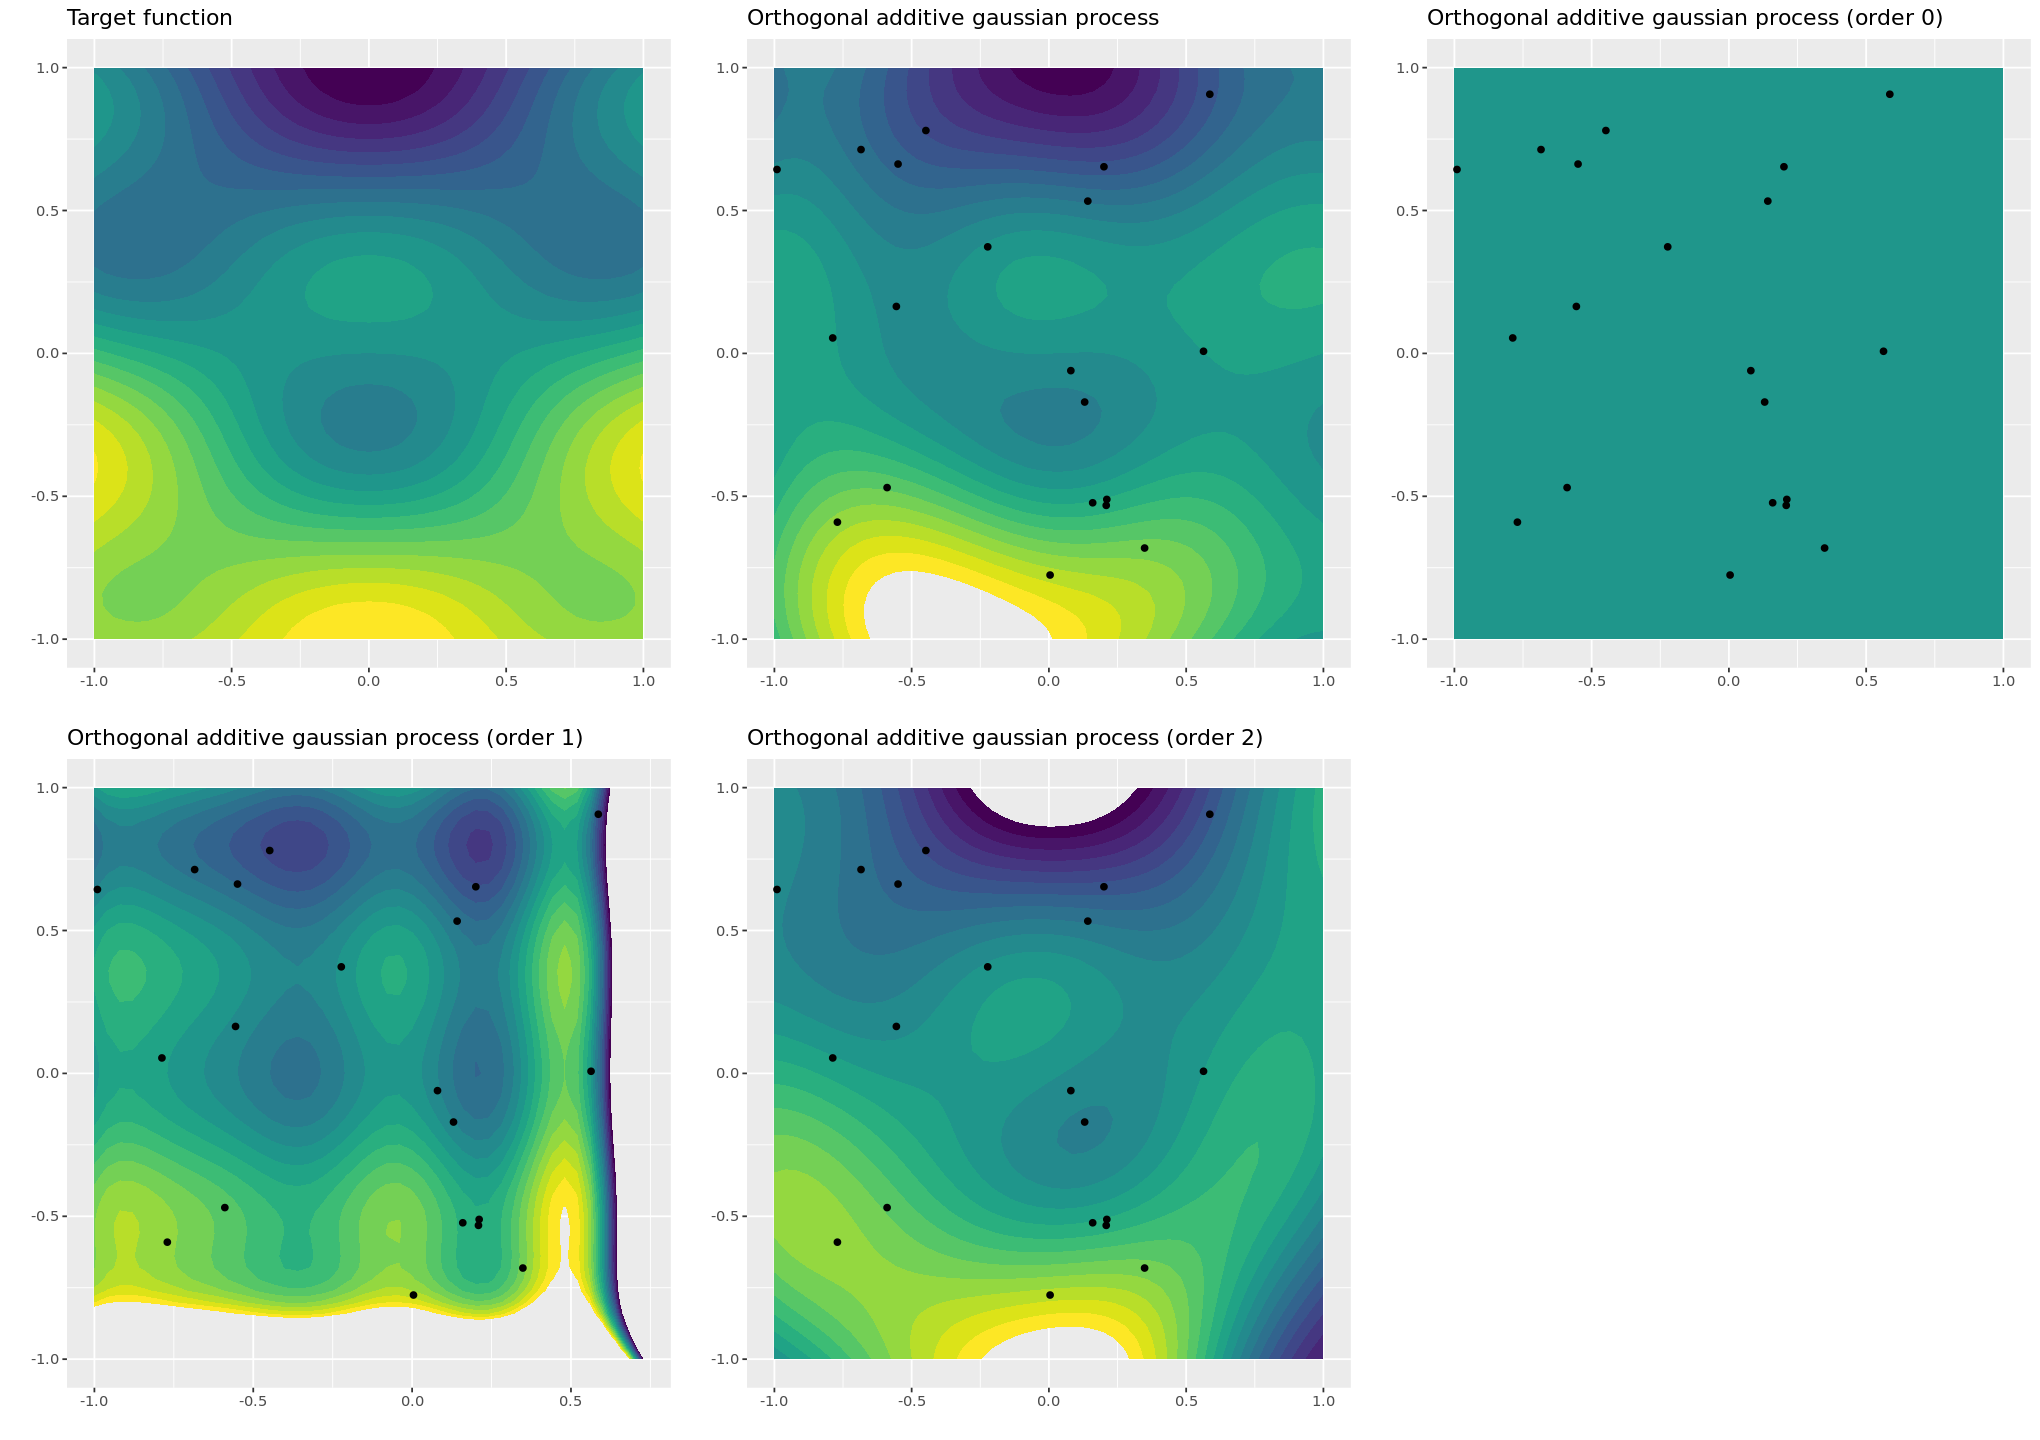

In [718]:
# Plot OAK-GP with fitted hyperparameters

l.oak.gaussian.plot <- l.oak.gaussian
sigma2.oak.gaussian.plot <- sigma2.oak.gaussian
n.plot.train.points <- 20
set.seed(221)

observed.x <- data.frame(x1=runif(n.plot.train.points, x.limits[1], x.limits[2]), 
                         x2=runif(n.plot.train.points, y.limits[1], y.limits[2]))
observed.y <- apply(observed.x, 1, f)

kernels <- list(build.k('oak.gaussian', l.oak.gaussian.plot, sigma2.oak.gaussian.plot),
                build.k('oak.gaussian0', l.oak.gaussian.plot, sigma2.oak.gaussian.plot), 
                build.k('oak.gaussian1', l.oak.gaussian.plot, sigma2.oak.gaussian.plot), 
                build.k('oak.gaussian2', l.oak.gaussian.plot, sigma2.oak.gaussian.plot))
titles <- list('Orthogonal additive gaussian process', 
               'Orthogonal additive gaussian process (order 0)', 
               'Orthogonal additive gaussian process (order 1)', 
               'Orthogonal additive gaussian process (order 2)')

plots <- list(plt.f)
for(i in seq_along(kernels)) {
    k <- kernels[[i]]
    title <- titles[[i]]
    
    gp.model <- calculate.regression.model(observed.x, observed.y, k)
    
    df.f.model <- df.f
    df.f.model$z <- gp.model$mean(xx)

    plt <- ggplot(df.f.model, aes(x=x, y=y, z=z)) +
      geom_contour_filled(
        breaks=color.breaks
      ) +
      geom_point(data=observed.x, aes(x=x1, y=x2, z=NULL)) +
      scale_fill_viridis_d(drop=FALSE) +
      theme(legend.position = "none") +
      xlab('') +
      ylab('') +
      ggtitle(title)
    plots <- append(plots, list(plt))
}

options(repr.plot.width=17, repr.plot.height=12)
plt2 <- plot_grid(plotlist=plots, ncol=3, align='h')
print(plt2)

# Confidence intervals for hyperparameters

In [528]:
# CI for different seeds

par.list <- list(
    ak=c('l1', 'l2', 'sigma1', 'sigma2', 'mse'),
    oak.gaussian=c('l1', 'l2', 'sigma1', 'sigma2', 'sigma3', 'mse')
    )

df.result <- list()
experiment.seed <- 12
n.iters <- 20
for(kernel.type in c('ak', 'oak.gaussian')) {
    df.result[[kernel.type]] <- data.frame()
    for(seed in seq(n.iters)) {
        set.seed(seed*experiment.seed)
        optim.params <- get.init.params(kernel.type)
        rand.initial.pars <- sapply(seq(length(par.list[[kernel.type]])-1), 
                                    function(i) runif(1, optim.params$lower.bounds[i], optim.params$upper.bounds[i]))
                                    
        optim.result <- optim(par=rand.initial.pars,
                              method='SAN',
                              #method='L-BFGS-B',
                              fn=calculate.params.ll,
                              lower=optim.params$lower.bounds,
                              upper=optim.params$upper.bounds,
                              control=list(
                                pgtol=0,
                                fnscale=fnscale,
                                temp=1000,
                                tmax=1000,
                                maxit=10000
                                ),
                              kernel.type=kernel.type,
                              verbose=FALSE
                              )
        cat('\nOptimization results:', sep='\n')
        cat(paste0(' Params=', paste0(optim.result$par, collapse=',')), sep='\n')
        cat(paste0(' Performance=', optim.result$value), sep='\n')
        if (kernel.type == 'ak') {
          cat(paste0(' Variance: ', 
                       paste0(formatC(optim.result$par[3:4]*100/sum(optim.result$par[3:4]), 
                                      format='f', digits=2), '%', collapse = ', '), 
                     sep='\n'))

          l <- optim.result$par[1:2]
          sigma2 <- optim.result$par[3:4]
        } else if (kernel.type == 'oak.gaussian') {
          cat(paste0(' Variance: ', 
                       paste0(formatC(optim.result$par[3:5]*100/sum(optim.result$par[3:5]), 
                                      format='f', digits=2), '%', collapse = ', '), 
                     sep='\n'))

          l <- optim.result$par[1:2]
          sigma2 <- optim.result$par[3:5]
        } else if (kernel.type == 'se') {
          l <- optim.result$par[1]
          sigma2 <- optim.result$par[2]
        }  
        df.result[[kernel.type]] <- rbind(df.result[[kernel.type]], c(kernel.type, optim.result$par, optim.result$value))
    }
    names(df.result[[kernel.type]]) <- c('kernel.type', par.list[[kernel.type]])
}

print(df.result)

Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=10,10,9.25396946003804,0
 Performance=0.00502292285132106
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=3.57167589537056,10,5.76350204906253,0
 Performance=0.0050376902263854
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=6.22755285023944,6.75823077327572,8.02289951127023,2.60308288270608
 Performance=0.0122671556733323
 Variance: 75.50%, 24.50%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.63648549388213,0.01,8.89849738817312,1.32924137298971
 Performance=0.00689738820900747
 Variance: 87.00%, 13.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=10,9.99999972325908,3.79666754296579,0
 Performance=0.00501940689163746
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=10,10,3.96628255924229,0
 Performance=0.00501941589037958
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=10,10,7.33212403335723,0
 Performance=0.0050212909859728
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=5.28281513023656,9.68784508462763,9.20529849128798,1.00320926867425
 Performance=0.0108344722113359
 Variance: 90.17%, 9.83%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=4.6576450328583,7.75075108963317,0.00159994416755507,10
 Performance=0.0104365574896682
 Variance: 0.02%, 99.98%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=4.64574687970893,7.72483282274849,0.00197467385922763,9.55244671828877
 Performance=0.0104375400415742
 Variance: 0.02%, 99.98%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=6.82607468938455,9.52661497248802,2.89466219488531,4.75124805467203
 Performance=0.0104847025067603
 Variance: 37.86%, 62.14%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.63646567488836,0.01,9.586495961014,1.43229867385325
 Performance=0.00689738819864786
 Variance: 87.00%, 13.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.63650494528621,0.01,10,1.49411886509617
 Performance=0.00689738820013702
 Variance: 87.00%, 13.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=4.65739475672259,7.75146779689637,0.0051096083424743,10
 Performance=0.0104365577845535
 Variance: 0.05%, 99.95%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=4.65740559383018,7.75279443686658,0.00366823022180319,9.99249790076338
 Performance=0.0104365760232611
 Variance: 0.04%, 99.96%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=8.42721915898845,1.91051126653794,5.5276310024783,2.4214651552029
 Performance=0.0410109000695151
 Variance: 69.54%, 30.46%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.63646502955645,0.01,9.99999967404092,1.49407585308173
 Performance=0.00689738819860637
 Variance: 87.00%, 13.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=10,10,6.96612920784205,0
 Performance=0.00502100259706123
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.63646633598701,0.01,9.54852923406067,1.42662959058463
 Performance=0.006897388198654
 Variance: 87.00%, 13.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=4.66799231301062,8.70973105312791,5.89232811238617,3.02809684537351
 Performance=0.0111620923706325
 Variance: 66.05%, 33.95%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.0111988171376377,1.80913845185989,6.09484062355885,10,1.68488628235631
 Performance=0.0142980511814691
 Variance: 34.28%, 56.24%, 9.48%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=9.20523340428481,2.80455837761285,7.63820461230353,8.01630616188049,2.54725093021989
 Performance=0.0815064398123246
 Variance: 41.96%, 44.04%, 13.99%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.163079353069221,9.99933520009423,8.14532843011626,0.000947322261646652,0.000640274589120714
 Performance=0.0557448917217717
 Variance: 99.98%, 0.01%, 0.01%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.19761139968876,9.81044235612266,0.383103066124022,7.85301141440868,4.63556412840262
 Performance=0.171078249447447
 Variance: 2.98%, 61.01%, 36.01%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=9.99999094847455,2.19199829089091,8.70318245346918,-1.6940658945086e-21,0.0217455127567694
 Performance=0.00783155123119503
 Variance: 99.75%, -0.00%, 0.25%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=5.10149438040854,10,6.66278603718459,3.95631526765764,0
 Performance=0.00503262034476716
 Variance: 62.74%, 37.26%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.4126557161976,1.37034831779881,3.18836346075101,6.00540417870586,0
 Performance=0.0065359521727883
 Variance: 34.68%, 65.32%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=3.45381234536724,9.62911066150794,7.69175150732637,6.51967846436981,0
 Performance=0.00504032559034815
 Variance: 54.12%, 45.88%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.142412644433476,2.87227989239352,0.95551158517505,6.80527367858329,3.5334640308291
 Performance=0.0169612777343114
 Variance: 8.46%, 60.25%, 31.29%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=6.10799924487311,9.95137150537161,0,8.60680952549709,0
 Performance=0.00503048717670312
 Variance: 0.00%, 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.82955030907536,9.99995299473863,0,0.300799967267477,7.61315698851292
 Performance=0.0113559008157165
 Variance: 0.00%, 3.80%, 96.20%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=3.07949343697702,0.436756287700583,7.28504280109726,0.986947334236506,8.13274559393733
 Performance=0.07124331839699
 Variance: 44.41%, 6.02%, 49.58%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=3.3764280893933,4.94588999453699,1.08273819088936,9.18934874702245,3.57421528780833
 Performance=0.0720760317399342
 Variance: 7.82%, 66.37%, 25.81%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=5.72240065081278,3.36937656570692,7.9059314285405,7.98020045505837,2.66089558368549
 Performance=0.0265136207427373
 Variance: 42.63%, 43.03%, 14.35%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.944499129452743,4.41382526984205,3.87831564294174,3.75431675231084,6.51545722037554
 Performance=2339.38160512979
 Variance: 27.41%, 26.54%, 46.05%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.43849311110796,3.36226597613189,6.06986211845651,1.43359578214586,7.78252633986995
 Performance=0.453331850632715
 Variance: 39.71%, 9.38%, 50.91%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.64773956435463,8.09534994314088,0.292653469377317,3.09313713056785,4.35247728394887
 Performance=0.0404414256100121
 Variance: 3.78%, 39.97%, 56.25%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=6.09530853767444,9.92422432470382,5.96022705804948,7.47432135341279,0
 Performance=0.00502332935593952
 Variance: 44.36%, 55.64%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=6.49671253825664,1.37874671446493,7.46393578451941,10,0
 Performance=0.00689635426053118
 Variance: 42.74%, 57.26%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=3.51855093840368,0.0159326719193384,2.68030092121012,8.33158246961053,0.45599909638446
 Performance=0.0106080980541092
 Variance: 23.37%, 72.65%, 3.98%
$ak
   kernel.type               l1               l2              sigma1
1           ak               10               10    9.25396946003804
2           ak 3.57167589537056               10    5.76350204906253
3           ak 6.22755285023944 6.75823077327572    8.02289951127023
4           ak 1.63648549388213             0.01    8.89849738817312
5           ak               10 9.99999972325908    3.79666754296579
6           ak               10               10    3.96628255924229
7           ak               10               10    7.33212403335723
8           ak 5.28281513023656 9.68784508462763    9.20529849128798
9           ak  4.6576450328583 7.75075108963317 0.00159994416755507
10          ak 4.64574687970893 7.72483282274849 0.00197467385922763
11          ak 6.82607468938455 9.52661497248802    2.

In [616]:
df.result

kernel.type,l1,l2,sigma1,sigma2,mse
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ak,10,10,9.25396946003804,0,0.00502292285132106
ak,3.57167589537056,10,5.76350204906253,0,0.0050376902263854
ak,6.22755285023944,6.75823077327572,8.02289951127023,2.60308288270608,0.0122671556733323
ak,1.63648549388213,0.01,8.89849738817312,1.32924137298971,0.00689738820900747
ak,10,9.99999972325908,3.79666754296579,0,0.00501940689163746
ak,10,10,3.96628255924229,0,0.00501941589037958
ak,10,10,7.33212403335723,0,0.0050212909859728
ak,5.28281513023656,9.68784508462763,9.20529849128798,1.00320926867425,0.0108344722113359
ak,4.6576450328583,7.75075108963317,0.00159994416755507,10,0.0104365574896682


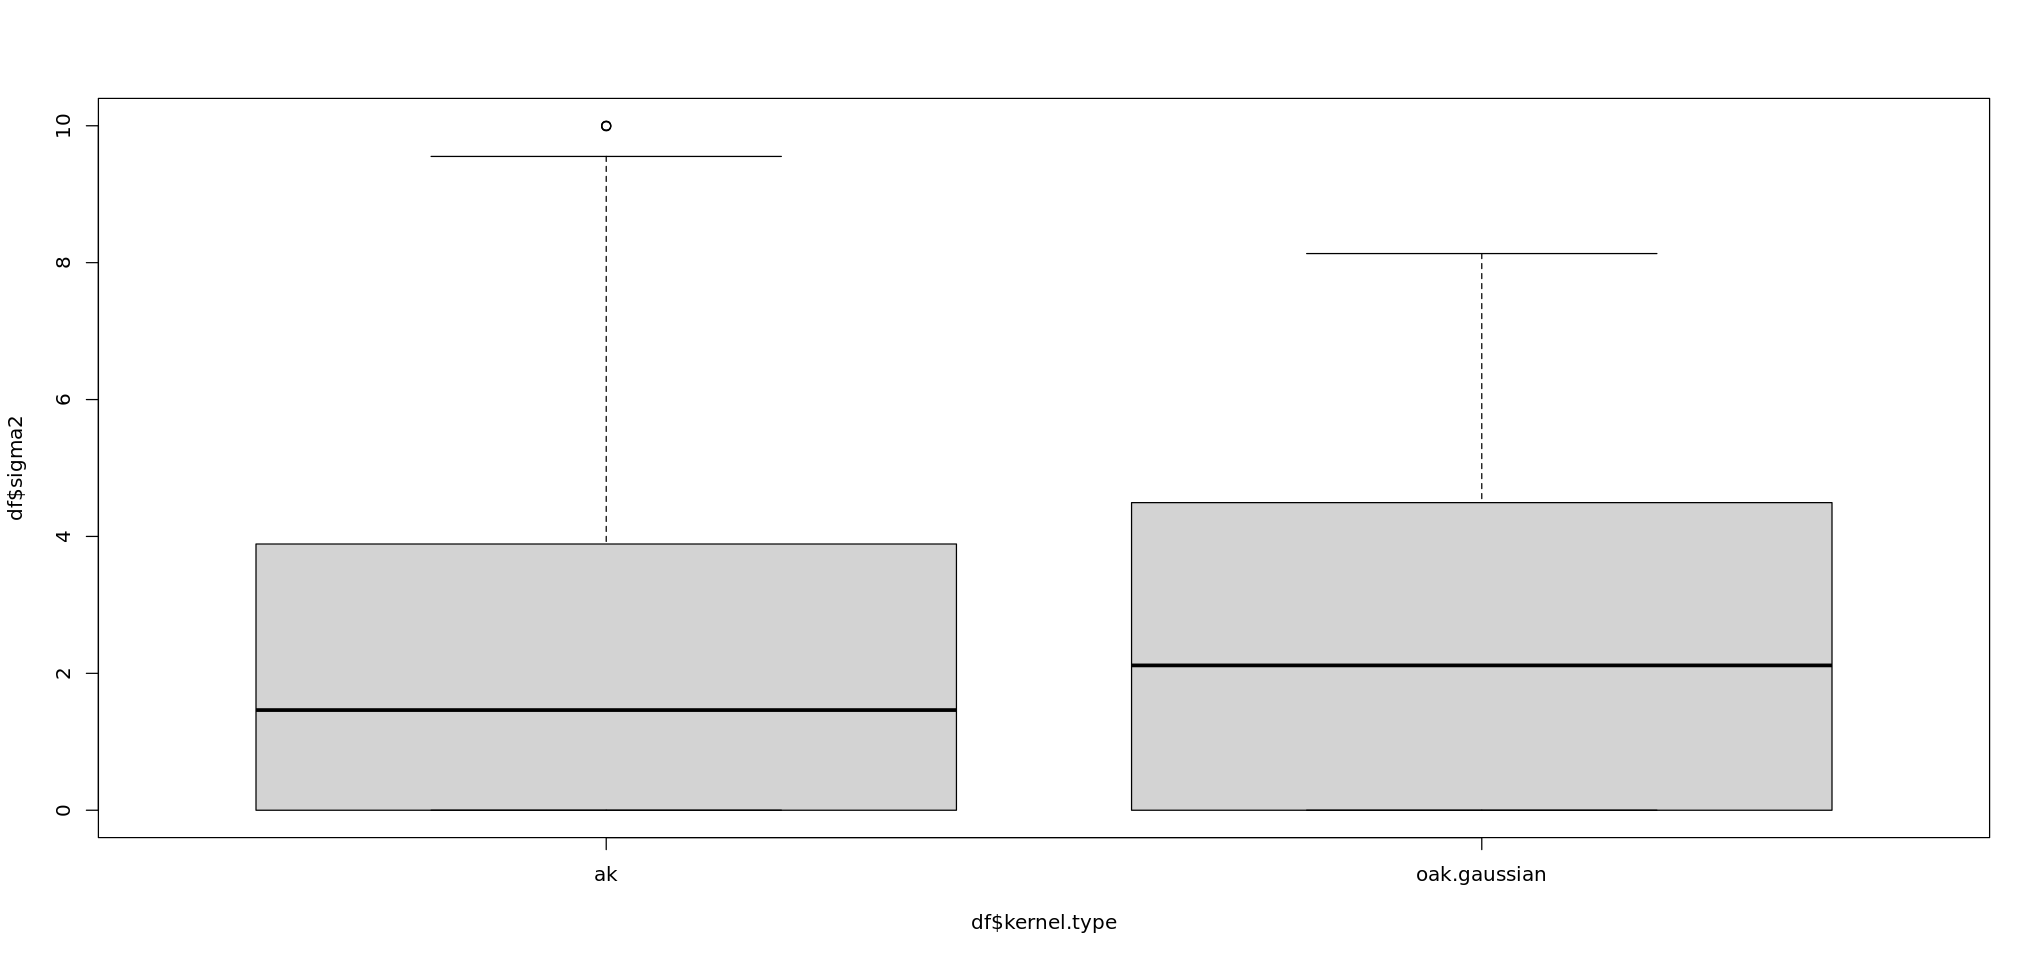

In [529]:
df <- df.result
df$ak$sigma0 <- NA
df$oak.gaussian$sigma0 <- df$oak.gaussian$sigma1
df$oak.gaussian$sigma1 <- df$oak.gaussian$sigma2
df$oak.gaussian$sigma2 <- df$oak.gaussian$sigma3
df$oak.gaussian$sigma3 <- NULL
df <- rbind(df$ak, df$oak.gaussian)
df[,2:7] <- lapply(df[,2:7], function(r) as.numeric(r))

options(repr.plot.width=17, repr.plot.height=8)
boxplot(df$sigma2 ~ df$kernel.type)

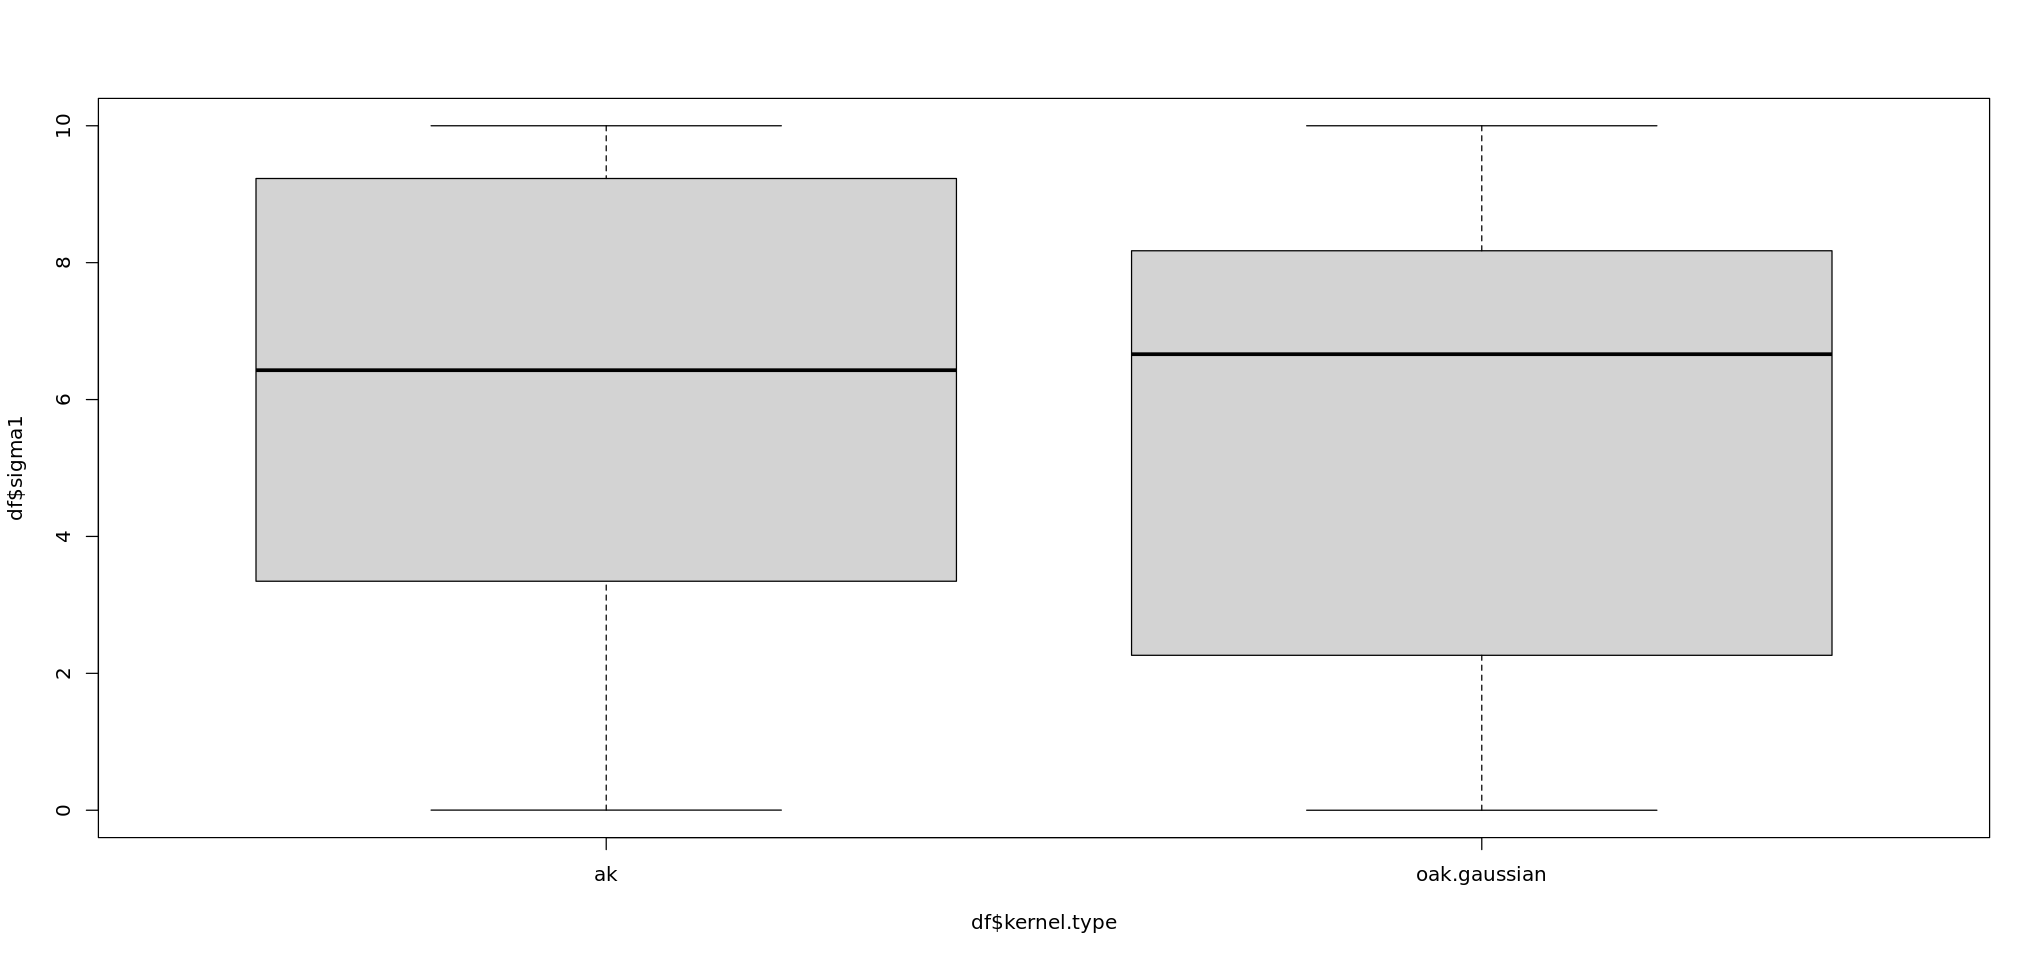

In [530]:
df2 <- df[df$mse<.001,]
options(repr.plot.width=17, repr.plot.height=8)
boxplot(df$sigma1 ~ df$kernel.type)

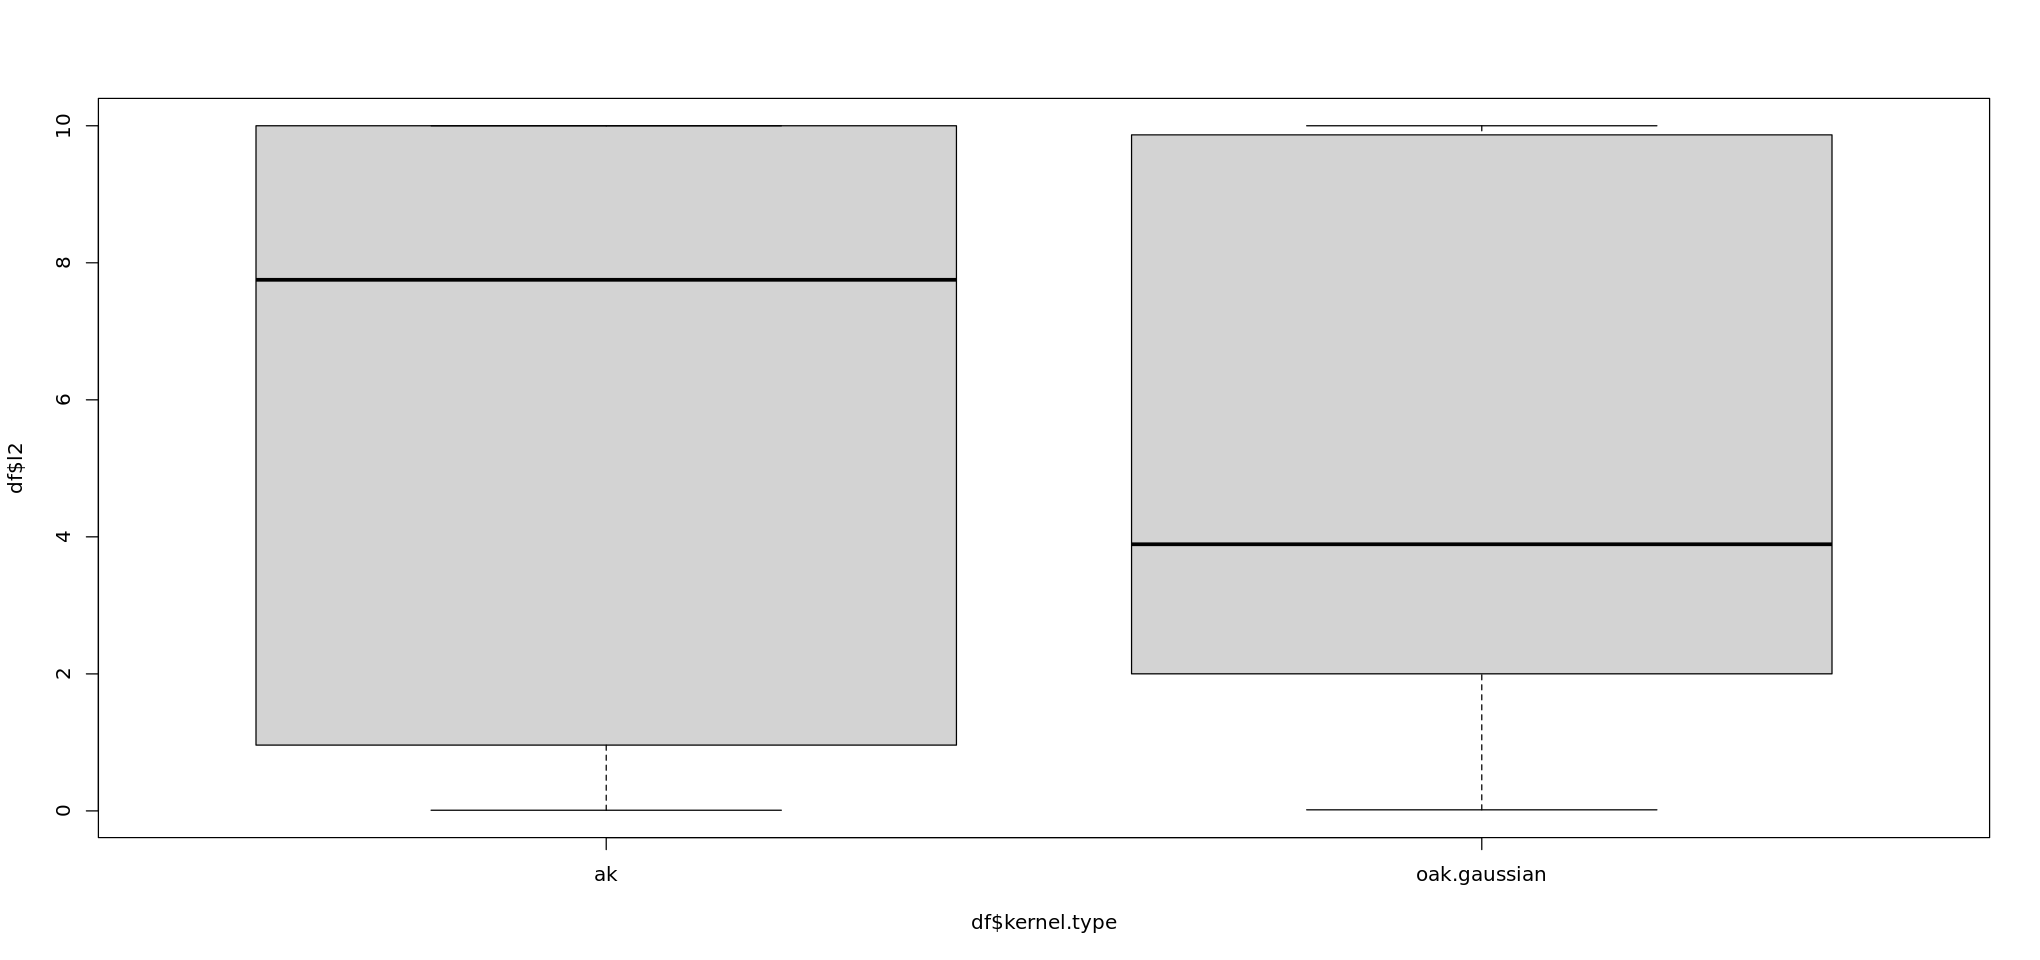

In [618]:
df2 <- df[df$mse<.001,]
options(repr.plot.width=17, repr.plot.height=8)
boxplot(df$l2 ~ df$kernel.type)